Importing libraries and modules:

In [1]:
%matplotlib inline 
#to generate figures directly in the notebook

# Libraries and Modules
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rcParams['text.usetex'] = True
import numpy as np
from numpy import *
from scipy.integrate import odeint
from scipy.optimize import *
import matplotlib.font_manager as fontman
arialfont = fontman.FontProperties(fname='fonts/arial.ttf')
arialbold = fontman.FontProperties(fname='fonts/arial_bold.ttf')
arialeb = fontman.FontProperties(fname='fonts/arialEB.otf')
from pathlib import Path
fpath = Path(mpl.get_data_path(), "fonts/arial_bold.ttf")

print(mpl.__version__) #check the matplotlib version

3.4.2


Setting physical parameters:

In [2]:
# Parameters and physical constants

h      = 6.62607004e-34   # [J*s]
kb     = 1.38064852e-23   # [J/K]
c      = 299792458        # [m/s]
Na     = 6.02214086e23    # [mol-1]
R      = kb*Na            # 8.314459865590527 [J/(mol*K)]
T      = 293              # [K]
    
C_kJ   = 4184 # 1kCal = 4184 J

print('RT   ', R*T) #check

# First order rate constants [s-1]

yc = 10 
gf = 10 
gc = 10
yf = 10

wm = 0.000008
um = 0.000008 
fm = 0.000000000000000000000000001

# Second order rate constants [(s*M)-1]

fp = 0.008 
hp = 0.002

wp = 0.00000000000000000000000001

# Rate constants set by thermodynamic constraints
hm = sqrt((hp*fm*yf*hp*fm*gf)/(fp*gc*fp*yc))
up = sqrt((um*yc*wp*um*gc*wp)/(gf*wm*yf*wm))


print('yc   ', yc)
print('gf   ', gf)
print('gc   ', gc)
print('yf   ', yf)
print('fp   ', fp)
print('hp   ', hp)
print('wm   ', wm)
print('um   ', um)
print('fm   ', fm)
print('hm   ', hm)
print('wp   ', wp)
print('up   ', up)

#Chemical potentials differencies:

DGT = -R*T*log(yc/gf) #Std Chem Pot DD - DH
DGT = -R*T*log(gc/yf) #Std Chem Pot HH - HD

muFmuW = R*T*log((fp*wm)/(fm*wp)) #Std chemical potential gradient F-W

DGf = -R*T*log(fp/fm)
DGh = -R*T*log(hp/hm)
DGw = -R*T*log(wp/wm)

print('DGT   ',DGT) 
print('muFmuW    ', muFmuW/(R*T))

### "standard" kinetic asymmetry
Kr_std  = ((hm+um)**2*yc*(fp+wp)**2*gc/((hp+up)**2*gf*(fm+wm)**2*yf))
print('Kr_std   ', Kr_std)


RT    2436.1367406180243
yc    10
gf    10
gc    10
yf    10
fp    0.008
hp    0.002
wm    8e-06
um    8e-06
fm    1e-27
hm    2.5e-28
wp    1e-26
up    1e-26
DGT    -0.0
muFmuW     105.47262717509768
Kr_std    16.0


Defining functions:

In [3]:
def SS_solution(ss,yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,HCl,LM):
    """
    This function takes as input kinetic constants, chemostatted concentrations of F and W, and conserved
    quantity LM. The output is a 6-d array named "ss" containing the stationary state concentrations of the
    internal species.
    """
    
    
    PH  = ss[0]
    PD  = ss[1]
    DH  = ss[2]
    HD  = ss[3]
    DD  = ss[4]
    HH  = ss[5]
                            
    H = empty((6))
    H[0] = -(hm*HCl+um+fm*HCl+wm)*PH + (hp*F0+up*W0)*DH + (fp*F0 + wp*W0)*HH  #PH
    H[1] = -(hm*HCl+um+fm*HCl+wm)*PD + (hp*F0+up*W0)*HD + (fp*F0 + wp*W0)*DD #PD
    H[2] = -(hp*F0+up*W0+yc)*DH + (hm*HCl+um)*PH + gf*DD  #DH
    H[3] = -(hp*F0+up*W0+gc)*HD + (hm*HCl+um)*PD + yf*HH  #HD
    H[4] = -(fp*F0+wp*W0+gf)*DD + (fm*HCl+wm)*PD + yc*DH  #DD
    H[5] = (PH + PD + DH + HD + DD + HH) - LM #conservation of motor
    return H

def DY_solution(y, t, params):
    """
    This function takes as input kinetic constants, chemostatted concentration of F and W, and conserved quantity 
    LM. The output is the list of rate equations of the kind dy[i]/dt = derivs[i] to
    solve numerically with scipy odeint in order to get the time evolution of concentrations from a certain 
    initial condition up tu a certain time. The conservation of the total amount of motor is "built-in" in writing
    HH as LM minus the sum of all other concentrations.
    """
    PH,PD,DH,HD,DD = y
    yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM = params
    derivs = [-(hm*HCl+um+fm*HCl+wm)*PH + (hp*F0+up*W0)*DH + (fp*F0 + wp*W0)*(LM - PH -PD -DH - HD -DD), #PH
              -(hm*HCl+um+fm*HCl+wm)*PD + (hp*F0+up*W0)*HD + (fp*F0 + wp*W0)*DD, #PD
              -(hp*F0+up*W0+yc)*DH + (hm*HCl+um)*PH + gf*DD, #DH
              -(hp*F0+up*W0+gc)*HD + (hm*HCl+um)*PD + yf*(LM - PH -PD -DH - HD -DD), #HD
              -(fp*F0+wp*W0+gf)*DD + (fm*HCl+wm)*PD + yc*DH] #DD
    return derivs

 Settings for the colormap:

In [4]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
                self.midpoint = midpoint
                colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
                x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
                return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


## Simulations

Varying chemical gationg in the fuelling reaction:

In [5]:
#simulation for fueling gating
SLP = []; Ratio = []; FPAVERAGE = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = []; FUELINGIFJ = [];
AFF = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];

GLOB_eff1 = []; GLOB_pow1 = []

#Conditions
W0 = 0.00001  ; LM = 0.01; HCl = 1e-18

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
fp_min = 1e-3; fp_max = 1e4; 
fr_min = 1e-2; fr_max = 1e2;
numf = 400;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; IFJ =[]; FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for somma in np.geomspace(fp_min,fp_max,numf):
        for r in np.geomspace(fr_min,fr_max,numf):
            
            
            flp = r*somma/(r+1)
            ylc = yc 
            glc = gc
            glf = gf
            ylf = yf
            flm = fm*(flp/fp) #assuming that the modification only affects the barriers 
            wlm = wm 
            wlp = wp
            ulm = um 
            hlp = flp/r 
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,HCl,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0*HCl))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm*HCl+hlm*HCl)*(ss[1] + ss[0])
            IFJ.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            Eff.append(ncd)
            
            GLOB_pow1.append(R*T*(imh+er))
            GLOB_eff1.append(ncd)
       
    FUELINGIFJ.append(np.array(IFJ))
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    #INFOFLOW.append(np.array(Imh))
    #ERATCHET.append(np.array(ER))

/home/emanuele/venv_research/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Varying chemical gationg in the waste-forming reaction:

In [6]:
#Simulation for the waste-forming gating

SLP = []; Ratio = [];
WASTINGJ = []; WASTINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = []; WASTINGIFJ = [];
AFF = []; 
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];

GLOB_eff2 = []; GLOB_pow2 = []

#Conditions
W0 = 0.00001  ; LM = 0.01; HCl = 1e-18

ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 

#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
wm_min = 1e-6; wm_max = 1e1#1e-1; 
rt_min = 1e-3; rt_max = 1e3;
numw = 400;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; IFJ = [];
    FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for somma in np.geomspace(wm_min,wm_max,numw):
        for r in np.geomspace(rt_min,rt_max,numw):
            
            ulm = r*somma/(r+1)
            wlm = ulm/r 
            ylc = yc 
            glc = gc
            glf = gf
            ylf = yf
            wlp = wp*(wlm/wm) #assuming that the modification only affects the barriers 
            flp = fp 
            flm = fm
            hlp = hp 
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))
   
            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,HCl,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0*HCl))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm*HCl+hlm*HCl)*(ss[1] + ss[0])
            IFJ.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            Eff.append(ncd)
            
            GLOB_pow2.append(R*T*(imh+er))
            GLOB_eff2.append(ncd)
    
    WASTINGIFJ.append(np.array(IFJ))
    WASTINGJ.append(np.array(Jt))
    WASTINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))

Varying binding site affinities:

In [7]:
# simulation for binding affinities
SLP = []; Ratio = [];
PSJ = []; PSEff = []; FUEL = []; PSI = []; PSIFJ = [];
AFF = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];

GLOB_eff3 = []; GLOB_pow3 = []

#Conditions
W0 = 0.00001  ; LM = 0.01; HCl = 1e-18

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 2e5; 
rt_min = 1; rt_max = 1e5;

numps = 400;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; JIF = [] ; FUEL.append(F0) #lits to renew on each cycles and collection of fuel values
    for somma in np.geomspace(sp_min,sp_max,numps):
        for r in np.geomspace(rt_min,rt_max,numps):
            

            ylc = r*somma/(r+1)
            ylf = ylc
            glf = ylc/r
            glc = glf
            wlm = wm 
            ulm = um 
            flm = fm 
            flp = fp 
            hlp = hp 
            wlp = wp
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,HCl,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0*HCl))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm*HCl+hlm*HCl)*(ss[1] + ss[0])
            JIF.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #efficiency
            ncd = R*T*imh/wch
            Eff.append(ncd)
            
            GLOB_pow3.append(R*T*(imh+er))
            GLOB_eff3.append(ncd)
    
    PSIFJ.append(np.array(JIF))
    PSJ.append(np.array(Jt))
    PSEff.append(np.array(Eff))
    PSI.append(np.array(Imh))


Introducing energy flow at constant kinetic asymmetry:

In [8]:
#simulation for energy flow at constant Kr
SLP = []; Ratio = [];
CKrJ = []; CKrEff = []; FUEL = []; CKrI = []; ERATCHET = []; CKrIFJ = [];
AFF = []; 
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];

GLOB_eff4 = []; GLOB_pow4 = []

#Conditions
W0 = 0.00001  ; LM = 0.01; HCl = 1e-18

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 

#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
spA_min = 1e-5; spA_max = 1e2; 
rtA_min = 1e-2; rtA_max = 1e2;
num1ck = 100; num2ck = 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; JIF = [] ; FUEL.append(F0) #lists to renew each cycles and collection of fuel values
    for somma in np.geomspace(spA_min,spA_max,num1ck):
        for r in np.geomspace(rtA_min,rtA_max,num2ck):
            
            
            ylc = r*somma/(r+1)
            
            glc = ylc
            glf = ylc/r
            ylf = glf
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp
            ulm = um 
            hlm = hm 
            hlp = sqrt((hlm*flp*glc*hlm*flp*ylc)/(flm*ylf*flm*glf))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,HCl,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0*HCl))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm*HCl+hlm*HCl)*(ss[1] + ss[0])
            JIF.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            Eff.append(ncd)
            
            GLOB_pow4.append(R*T*(imh+er))
            GLOB_eff4.append(ncd)
    
    CKrI.append(np.array(Imh))
    CKrJ.append(np.array(Jt))
    CKrEff.append(np.array(Eff))
    CKrIFJ.append(np.array(JIF))


Introducing energy flow and varying kinetic asymmetry:

In [9]:
#energy flow with varying Kr

SLP = []; Ratio = [];
VKrJ = []; VKrEff = []; FUEL = []; VKrI = []; ERATCHET = []; VKrIFJ = []; 
AFF = []; 
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];

GLOB_eff5 = []; GLOB_pow5 = []

#Conditions
W0 = 0.00000001  ; LM = 0.01; HCL = 1e-18

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 

#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
spB_min = 1e-4; spB_max = 1e2; 
rtB_min = 5e-4; rtB_max = 5e2;
num1vk = 100; num2vk= 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; JIF = []; FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for somma in np.geomspace(spB_min,spB_max,num1vk):
        for r in np.geomspace(rtB_min,rtB_max,num2vk):
            
            ylc = r*somma/(r+1)
        
            glc = ylc
            glf = ylc/r
            ylf = glf
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp
            ulm = um
            hlp = hp 
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,HCl,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0*HCl))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm*HCl+hlm*HCl)*(ss[1] + ss[0])
            JIF.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            Eff.append(ncd)
            
            GLOB_pow5.append(R*T*(imh+er))
            GLOB_eff5.append(ncd)
    
    VKrIFJ.append(np.array(JIF))
    VKrJ.append(np.array(Jt))
    VKrEff.append(np.array(Eff))
    VKrI.append(np.array(Imh))
    ERATCHET.append(np.array(ER))

Double chemical gating:

In [10]:
#simulation for double gating
SLP = []; Ratio = []; FPAVERAGE = [];
DGJ = []; DGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = []; DGIFJ = [];
AFF = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];

GLOB_eff6 = []; GLOB_pow6 = []

#Conditions
W0 = 0.00001  ; LM = 0.01; HCl = 1e-18

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 

#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
fr_min = 1e-2; fr_max = 1e2;
numf = 400;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; IFJ =[]; FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for rfg in np.geomspace(fr_min,fr_max,numf):
        for rwg in np.geomspace(fr_min,fr_max,numf):
            
            flp = rfg*(fp + hp)/(rfg+1)
            ulm = rwg*(wm + um)/(rwg+1)
            hlp = flp/rfg 
            wlm = ulm/rwg 
            
            ylc = yc 
            glc = gc
            glf = gf
            ylf = yf
            
            flm = fm*(flp/fp) #assuming that the modification only affects the barriers 
            wlp = wp*(wlm/wm)
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,HCl,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
    
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0*HCl))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm*HCl+hlm*HCl)*(ss[1] + ss[0])
            IFJ.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            Eff.append(ncd)
            
            GLOB_pow6.append(R*T*(imh+er))
            GLOB_eff6.append(ncd)
       
    DGIFJ.append(np.array(IFJ))
    DGJ.append(np.array(Jt))
    DGEff.append(np.array(Eff))
    #INFOFLOW.append(np.array(Imh))
    #ERATCHET.append(np.array(ER))

Computing values for experimental conditions:

In [11]:
#quick computations for experimental conditions
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 

F0 = 0.03; W0 = 0.00001  ; LM = 0.01; HCl = 1e-18
ss = fsolve(SS_solution,ssGuess,args=(yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,HCl,LM))

#affinity/force
aff = R*T*log((fp*wm)/(fm*wp)) + R*T*(log(F0) - log(W0))

#currents
jss = yc*ss[2] - gf*ss[4]
ifuel = F0*(fp*ss[4] + fp*ss[5] + hp*ss[2] + hp*ss[3]) - (fm*HCl+hm*HCl)*(ss[1] + ss[0])

#work
wch = ifuel*aff

#info
imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))

#energy ratchet
er = jss*log((yc*gc)/(gf*yf))

#efficiency
ncd = R*T*(imh+er)/wch 
      
print(jss)
print(ncd)

2.168663724858369e-08
2.3792656927686488e-08


## Figures

Figure 3:

/tmp/ipykernel_4540/3544794701.py:17: UserWarning: The following kwargs were not used by contour: 'clim'
  im00 = f3[0,0].contourf(xf,yf,np.array(FUELINGJ).reshape(len(yf),len(xf),order='F'),20,clim=( min(FUELINGJ[0]), max(FUELINGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(FUELINGJ[0]), vmax=max(FUELINGJ[0])))
/tmp/ipykernel_4540/3544794701.py:42: UserWarning: The following kwargs were not used by contour: 'clim'
  im01 = f3[0,1].contourf(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),20,clim=( min(CKrJ[0]), max(CKrJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(CKrJ[0]), vmax=max(CKrJ[0])))
/tmp/ipykernel_4540/3544794701.py:45: UserWarning: No contour levels were found within the data range.
  f3[0,1].contour(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),[0.0],linewidths=3.0 ,colors='w')
/tmp/ipykernel_4540/3544794701.py:72: UserWarning: The following kwargs were not used by contour: 'clim'
  im02 = f3[0,2].contourf(xps,yps,np.array(PSJ).reshap

Text(-0.25, -0.1, 'f')

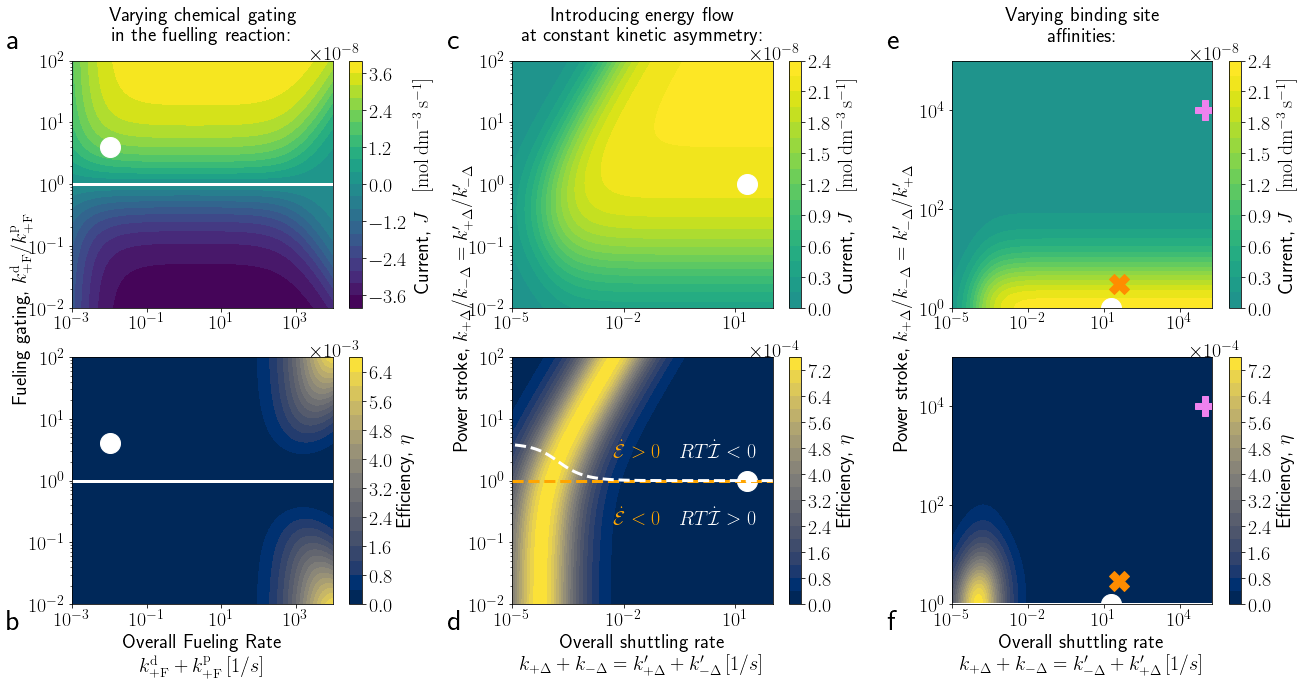

In [12]:
xf=np.unique(np.geomspace(fp_min,fp_max,numf))
yf=np.unique(np.geomspace(fr_min,fr_max,numf))
xps=np.unique(np.geomspace(sp_min,sp_max,numps))
yps=np.unique(np.geomspace(rt_min,rt_max,numps))
xck=np.unique(np.geomspace(spA_min,spA_max,num1ck))
yck=np.unique(np.geomspace(rtA_min,rtA_max,num2ck))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

mar = 20 #markersize
labs = 20 #labelsize

Figure3, f3 = plt.subplots(2,3, figsize=(21.6,10), sharex=False)

#fueling gating
im00 = f3[0,0].contourf(xf,yf,np.array(FUELINGJ).reshape(len(yf),len(xf),order='F'),20,clim=( min(FUELINGJ[0]), max(FUELINGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(FUELINGJ[0]), vmax=max(FUELINGJ[0])))
f3[0,0].set_ylabel('Fueling gating, ${k^\mathrm{d}_{+\mathrm{F}}}/{k^\mathrm{p}_{+\mathrm{F}}}$',fontproperties=arialfont,linespacing=1.5,size=labs)
f3[0,0].yaxis.set_label_coords(-0.15, 0.0)
f3[0,0].contour(xf,yf,np.array(FUELINGJ).reshape(len(yf),len(xf),order='F'),[0.0],linewidths=3.0 ,colors='w')
f3[0,0].set_xscale('log')
f3[0,0].set_yscale('log')
f3[0,0].plot(fp+hp,fp/hp, marker='o',markersize=mar,c='w')
cbar00 = Figure3.colorbar(im00, shrink=1.0, ax=f3[0,0])
cbar00.set_label("Current, $J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",fontproperties=arialfont,size=labs)

im10 = f3[1,0].contourf(xf,yf,np.array(FUELINGEff).reshape(len(yf),len(xf),order='F'),20, cmap='cividis')
f3[1,0].set_xscale('log')
f3[1,0].set_yscale('log')
f3[1,0].set_xlabel('Overall Fueling Rate \n $k^\mathrm{d}_{+\mathrm{F}}+k^\mathrm{p}_{+\mathrm{F}} \, [1/s]$',fontproperties=arialfont,size=labs)
f3[1,0].axhline(y=1, c='w', linestyle='-',linewidth=3.0) 
f3[1,0].plot(fp+hp,fp/hp, marker='o',markersize=mar,c='w')
cbar10 = Figure3.colorbar(im10, shrink=1.0, ax=f3[1,0])
cbar10.set_label("Efficiency, $\eta$",fontproperties=arialfont,size=labs)
cbar10.formatter.set_powerlimits((0, 0))
cbar10.update_ticks()

f3[0,0].set_title("Varying chemical gating \n in the fuelling reaction:",fontproperties=arialfont, size=labs ,pad= 20)


#energy flow at constant Kr
im01 = f3[0,1].contourf(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),20,clim=( min(CKrJ[0]), max(CKrJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(CKrJ[0]), vmax=max(CKrJ[0])))
f3[0,1].set_ylabel("Power stroke, ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",fontproperties=arialfont,linespacing=1.5,size=labs)
f3[0,1].yaxis.set_label_coords(-0.15,0.0)
f3[0,1].contour(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),[0.0],linewidths=3.0 ,colors='w')
f3[0,1].set_xscale('log')
f3[0,1].set_yscale('log')
f3[0,1].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar01 = Figure3.colorbar(im01, shrink=1.0, ax=f3[0,1])
cbar01.set_label("Current, $J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",fontproperties=arialfont,size=labs)
                                                                                                    
im11 = f3[1,1].contourf(xck,yck,np.array(CKrEff).reshape(len(yck),len(xck),order='F'),20, cmap='cividis')
f3[1,1].set_xscale('log')
f3[1,1].set_yscale('log')
f3[1,1].set_xlabel("Overall shuttling rate \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \, [1/s]$",fontproperties=arialfont,size=labs)
f3[1,1].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar11 = Figure3.colorbar(im11, shrink=1.0, ax=f3[1,1])
cbar11.set_label("Efficiency, $\eta$",fontproperties=arialfont,size=labs)
cbar11.formatter.set_powerlimits((0, 0))
cbar11.update_ticks()

f3[1,1].axhline(y=1, c='orange', linestyle='--',linewidth=3.0, zorder=5) 
f3[1,1].contour(xck,yck,np.array(CKrI).reshape(len(yck),len(xck),order='F'),[0.0],linewidths=3.0,linestyles='--' ,colors='w',zorder=10)
f3[1,1].text(0.3, 2.5, '$RT\dot{\mathcal{I}}<0$',size=labs, color='w')
f3[1,1].text(0.3, 0.2, '$RT\dot{\mathcal{I}}>0$',size=labs, color='w')
f3[1,1].text(0.005, 2.5, '$\dot{\mathcal{E}}>0$',size=labs, color='orange')
f3[1,1].text(0.005, 0.2, '$\dot{\mathcal{E}}<0$',size=labs, color='orange')

f3[0,1].set_title("Introducing energy flow \n at constant kinetic asymmetry:",fontproperties=arialfont, pad= 20, size=labs)

#binding affinities
im02 = f3[0,2].contourf(xps,yps,np.array(PSJ).reshape(len(yps),len(xps),order='F'),20,clim=( min(PSJ[0]), max(PSJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(PSJ[0]), vmax=max(PSJ[0])))
f3[0,2].set_ylabel("Power stroke, $k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$",fontproperties=arialfont,linespacing=1.5,size=labs)
f3[0,2].yaxis.set_label_coords(-0.15,0.0)
f3[0,2].contour(xps,yps,np.array(PSJ).reshape(len(yps),len(xps),order='F'),[0.0],linewidths=3.0 ,colors='w')
f3[0,2].set_xscale('log')
f3[0,2].set_yscale('log')
f3[0,2].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
f3[0,2].plot(1e4*gf,1e4, marker='P',markersize=mar,c='violet')
f3[0,2].plot(4*gf,3, marker='X',markersize=mar,c='darkorange')
cbar01 = Figure3.colorbar(im01, shrink=1.0, ax=f3[0,2])
cbar01.set_label("Current, $J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",fontproperties=arialfont, size=labs)

im12 = f3[1,2].contourf(xps,yps,np.array(PSEff).reshape(len(yps),len(xps),order='F'),20, cmap='cividis')
f3[1,2].set_xscale('log')
f3[1,2].set_yscale('log')
f3[1,2].set_xlabel("Overall shuttling rate \n $k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \, [1/s]$",fontproperties=arialfont,size=labs)
f3[1,2].axhline(y=1, c='w', linestyle='-',linewidth=3.0) 
f3[1,2].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
f3[1,2].plot(1e4*gf,1e4, marker='P',markersize=mar,c='violet')
f3[1,2].plot(4*gf,3, marker='X',markersize=mar,c='darkorange')
cbar12 = Figure3.colorbar(im12, shrink=1.0, ax=f3[1,2])
cbar12.set_label("Efficiency, $\eta$",fontproperties=arialfont, fontsize=labs)
cbar12.formatter.set_powerlimits((0, 0))
cbar12.update_ticks()


f3[0,2].set_title("Varying binding site \n affinities:", pad= 20, fontproperties=arialfont, fontsize=labs)


#Final adjustments and labeling in Helvetica

Figure3.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.2)


f3[0,0].text(-0.25, 1.05, 'a', fontproperties=arialbold ,transform=f3[0,0].transAxes,  fontsize=30,  fontweight='bold')
f3[0,1].text(-0.25, 1.05, 'c', fontproperties=arialbold ,transform=f3[0,1].transAxes,  fontsize=30,  fontweight='bold')
f3[0,2].text(-0.25, 1.05, 'e', fontproperties=arialbold ,transform=f3[0,2].transAxes,  fontsize=30,  fontweight='bold')
f3[1,0].text(-0.25, -0.1, 'b', fontproperties=arialbold , transform=f3[1,0].transAxes, fontsize=30,  fontweight='bold')
f3[1,1].text(-0.25, -0.1, 'd', fontproperties=arialbold ,transform=f3[1,1].transAxes,  fontsize=30,  fontweight='bold')
f3[1,2].text(-0.25, -0.1, 'f', fontproperties=arialbold ,transform=f3[1,2].transAxes,  fontsize=30,  fontweight='bold')


Supplementary Figure 1

/tmp/ipykernel_4540/2777789832.py:14: UserWarning: The following kwargs were not used by contour: 'clim'
  im0 = s1[0].contourf(xf,yf,np.array(FUELINGJ).reshape(len(yf),len(xf),order='F'),20,clim=( min(FUELINGJ[0]), max(FUELINGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(FUELINGJ[0]), vmax=max(FUELINGJ[0])))
/tmp/ipykernel_4540/2777789832.py:33: UserWarning: The following kwargs were not used by contour: 'clim'
  im2 = s1[2].contourf(xf,yf,np.array(FUELINGIFJ).reshape(len(yf),len(xf),order='F'),20,clim=( min(FUELINGIFJ[0]), max(FUELINGIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(FUELINGIFJ[0]), vmax=max(FUELINGIFJ[0])))


Text(-0.15, 1.0, 'c')

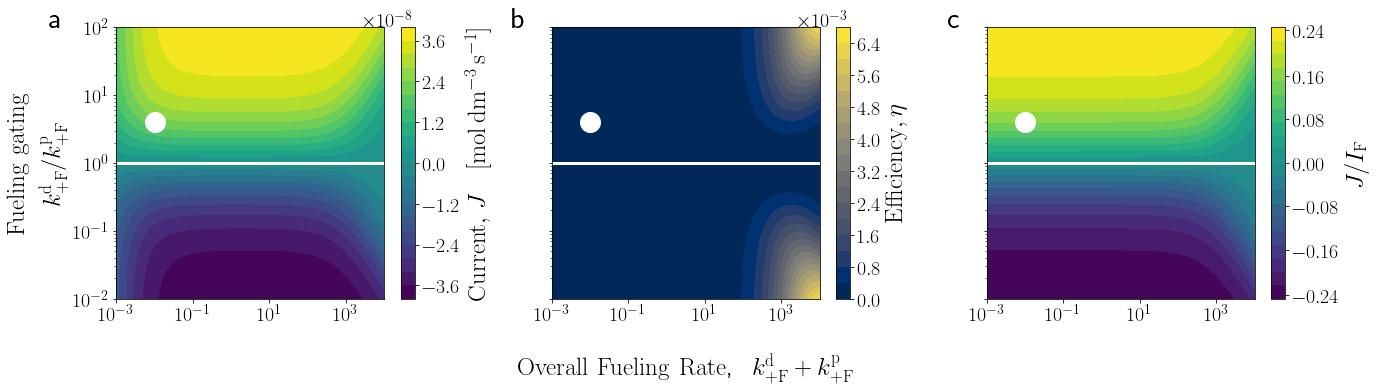

In [13]:
FigureS1, s1 = plt.subplots(1,3, figsize=(21.6,5), sharex=True, sharey=True)


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

xf=np.unique(np.geomspace(fp_min,fp_max,numf))
yf=np.unique(np.geomspace(fr_min,fr_max,numf))

mar = 20 #markersize
labs = 25 #labelsize

#fueling gating
im0 = s1[0].contourf(xf,yf,np.array(FUELINGJ).reshape(len(yf),len(xf),order='F'),20,clim=( min(FUELINGJ[0]), max(FUELINGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(FUELINGJ[0]), vmax=max(FUELINGJ[0])))
s1[0].contour(xf,yf,np.array(FUELINGJ).reshape(len(yf),len(xf),order='F'),[0.0],linewidths=3.0 ,colors='w')
s1[0].set_xscale('log')
s1[0].set_yscale('log')
s1[0].plot(fp+hp,fp/hp, marker='o',markersize=mar,c='w')
cbar0 = FigureS1.colorbar(im0, shrink=1.0, ax=s1[0])
cbar0.set_label("$\mathrm{Current}, \, J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",size=labs)

im1 = s1[1].contourf(xf,yf,np.array(FUELINGEff).reshape(len(yf),len(xf),order='F'),20, cmap='cividis')
s1[1].set_xscale('log')
s1[1].set_yscale('log')
s1[1].axhline(y=1, c='w', linestyle='-',linewidth=3.0) 
s1[1].plot(fp+hp,fp/hp, marker='o',markersize=mar,c='w')
cbar1 = FigureS1.colorbar(im1, shrink=1.0, ax=s1[1])
cbar1.set_label("$\mathrm{Efficiency}, \eta$",size=labs)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()

#fueling gating
im2 = s1[2].contourf(xf,yf,np.array(FUELINGIFJ).reshape(len(yf),len(xf),order='F'),20,clim=( min(FUELINGIFJ[0]), max(FUELINGIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(FUELINGIFJ[0]), vmax=max(FUELINGIFJ[0])))
s1[2].contour(xf,yf,np.array(FUELINGIFJ).reshape(len(yf),len(xf),order='F'),[0.0],linewidths=3.0 ,colors='w')
s1[2].set_xscale('log')
s1[2].set_yscale('log')
s1[2].plot(fp+hp,fp/hp, marker='o',markersize=mar,c='w')
cbar2 = FigureS1.colorbar(im2, shrink=1.0, ax=s1[2],ticks=[-0.24,-0.16,-0.08,0.00,0.08,0.16,0.24]) #format='%.2f') #the format option changes the font, do I went for brute force
cbar2.set_label("$J/I_\mathrm{F}$",size=labs)


#settings
FigureS1.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3)

s1[0].set_ylabel('$\mathrm{Fueling \, \, gating}$ \n ${k^\mathrm{d}_{+\mathrm{F}}}/{k^\mathrm{p}_{+\mathrm{F}}}$',linespacing=1.5,size=labs)
s1[1].set_xlabel('$\mathrm{Overall \, \, Fueling \, \, Rate}$, \, $k^\mathrm{d}_{+\mathrm{F}}+k^\mathrm{p}_{+\mathrm{F}}$',size=labs)
s1[1].xaxis.set_label_coords(0.5,-0.2)

s1[0].text(-0.25, 1.0, 'a', fontproperties=arialbold ,transform=s1[0].transAxes,  fontsize=30,  fontweight='bold')
s1[1].text(-0.15, 1.0, 'b', fontproperties=arialbold ,transform=s1[1].transAxes,  fontsize=30,  fontweight='bold')
s1[2].text(-0.15, 1.0, 'c', fontproperties=arialbold ,transform=s1[2].transAxes,  fontsize=30,  fontweight='bold')


Supplementary Figure 2

/tmp/ipykernel_4540/2093658477.py:17: UserWarning: The following kwargs were not used by contour: 'clim'
  im0 = sW[0].contourf(xw,yw,np.array(WASTINGJ).reshape(len(yw),len(xw),order='F'),20,clim=( min(WASTINGJ[0]), max(WASTINGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(WASTINGJ[0]), vmax=max(WASTINGJ[0])))
/tmp/ipykernel_4540/2093658477.py:36: UserWarning: The following kwargs were not used by contour: 'clim'
  im2 = sW[2].contourf(xw,yw,np.array(WASTINGIFJ).reshape(len(yw),len(xw),order='F'),20,clim=( min(WASTINGIFJ[0]), max(WASTINGIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(WASTINGIFJ[0]), vmax=max(WASTINGIFJ[0])))


Text(-0.15, 1.0, 'c')

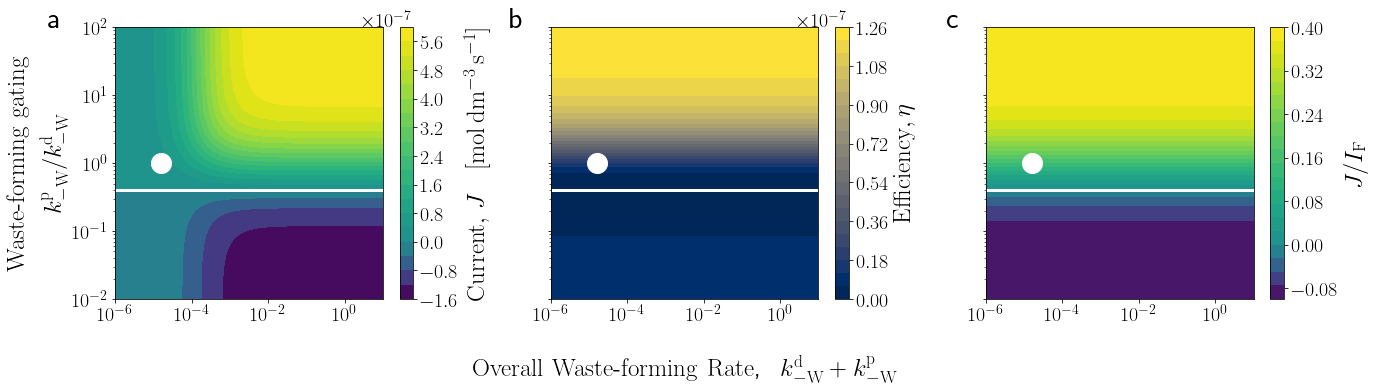

In [14]:
FigureSW, sW = plt.subplots(1,3, figsize=(21.6,5), sharex=True, sharey=True)


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)


xw=np.unique(np.geomspace(wm_min,wm_max,numw))
yw=np.unique(np.geomspace(fr_min,fr_max,numw))

mar = 20 #markersize
labs = 25 #labelsize



#wasting gating
im0 = sW[0].contourf(xw,yw,np.array(WASTINGJ).reshape(len(yw),len(xw),order='F'),20,clim=( min(WASTINGJ[0]), max(WASTINGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(WASTINGJ[0]), vmax=max(WASTINGJ[0])))
sW[0].contour(xw,yw,np.array(WASTINGJ).reshape(len(yw),len(xw),order='F'),[0.0],linewidths=3.0 ,colors='w')
sW[0].set_xscale('log')
sW[0].set_yscale('log')
sW[0].plot(wm+um,um/wm, marker='o',markersize=mar,c='w')
cbar0 = FigureSW.colorbar(im0, shrink=1.0, ax=sW[0])
cbar0.set_label("$\mathrm{Current}, \, J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",size=labs)

im1 = sW[1].contourf(xw,yw,np.array(WASTINGEff).reshape(len(yw),len(xw),order='F'),20, cmap='cividis')
sW[1].contour(xw,yw,np.array(WASTINGJ).reshape(len(yw),len(xw),order='F'),[0.0],linewidths=3.0 ,colors='w')
sW[1].set_xscale('log')
sW[1].set_yscale('log')
sW[1].plot(wm+um,um/wm, marker='o',markersize=mar,c='w')
cbar1 = FigureSW.colorbar(im1, shrink=1.0, ax=sW[1])
cbar1.set_label("$\mathrm{Efficiency}, \eta$",size=labs)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()

#fueling gating
im2 = sW[2].contourf(xw,yw,np.array(WASTINGIFJ).reshape(len(yw),len(xw),order='F'),20,clim=( min(WASTINGIFJ[0]), max(WASTINGIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(WASTINGIFJ[0]), vmax=max(WASTINGIFJ[0])))
sW[2].contour(xw,yw,np.array(WASTINGIFJ).reshape(len(yw),len(xw),order='F'),[0.0],linewidths=3.0 ,colors='w')
sW[2].set_xscale('log')
sW[2].set_yscale('log')
sW[2].plot(wm+um,um/wm, marker='o',markersize=mar,c='w')
cbar2 = FigureSW.colorbar(im2, shrink=1.0, ax=sW[2],ticks=[-0.08,0.00,0.08,0.16,0.24,0.32,0.40])
cbar2.set_label("$J/I_\mathrm{F}$",size=labs)


#settings
FigureSW.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3)

sW[0].set_ylabel('$\mathrm{Waste\mbox{-}forming \, \, gating}$\n ${k^\mathrm{p}_{-\mathrm{W}}}/{k^\mathrm{d}_{-\mathrm{W}}}$',linespacing=1.5,size=labs,)
sW[1].set_xlabel('$\mathrm{Overall \, \, Waste\mbox{-}forming \, \, Rate}$, \, $k^\mathrm{d}_{-\mathrm{W}}+k^\mathrm{p}_{-\mathrm{W}}$',size=labs)
sW[1].xaxis.set_label_coords(0.5,-0.2)

sW[0].text(-0.25, 1.0, 'a', fontproperties=arialbold ,transform=sW[0].transAxes,  fontsize=30,  fontweight='bold')
sW[1].text(-0.15, 1.0, 'b', fontproperties=arialbold ,transform=sW[1].transAxes,  fontsize=30,  fontweight='bold')
sW[2].text(-0.15, 1.0, 'c', fontproperties=arialbold ,transform=sW[2].transAxes,  fontsize=30,  fontweight='bold')


Supplementary Figure 3:

/tmp/ipykernel_4540/3207785627.py:12: UserWarning: The following kwargs were not used by contour: 'clim'
  im0 = e1[0].contourf(xdg,ydg,np.array(DGJ).reshape(len(ydg),len(xdg),order='F'),20,clim=( min(DGJ[0]), max(DGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(DGJ[0]), vmax=max(DGJ[0])))
/tmp/ipykernel_4540/3207785627.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  im2 = e1[2].contourf(xdg,ydg,np.array(DGIFJ).reshape(len(ydg),len(xdg),order='F'),20,clim=( min(DGIFJ[0]), max(DGIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(DGIFJ[0]), vmax=max(DGIFJ[0])))


Text(-0.15, 1.0, 'c')

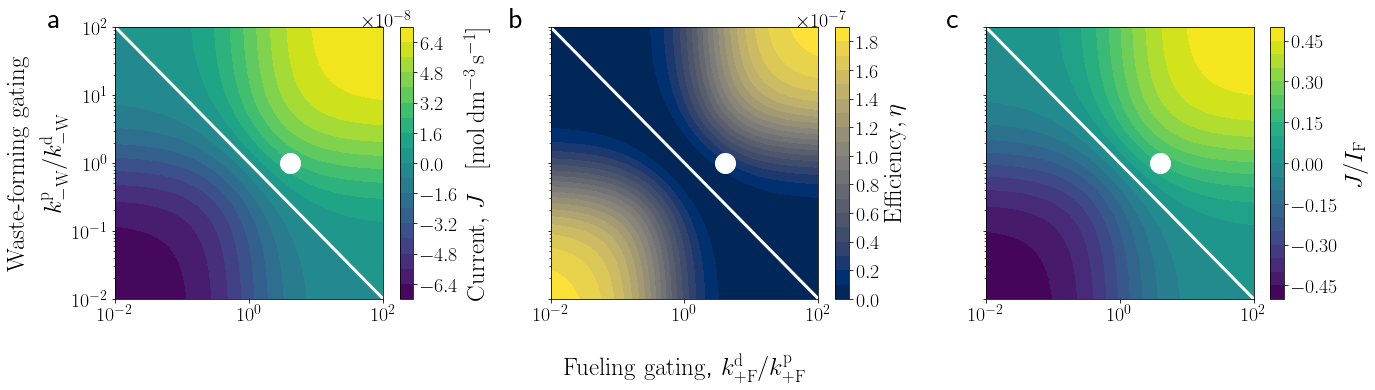

In [15]:
FigureE1, e1 = plt.subplots(1,3, figsize=(21.6,5), sharex=True, sharey=True)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

mar = 20 #markersize
labs = 25 #labelsize

xdg = np.geomspace(fr_min,fr_max,numf)
ydg = np.geomspace(fr_min,fr_max,numf)

im0 = e1[0].contourf(xdg,ydg,np.array(DGJ).reshape(len(ydg),len(xdg),order='F'),20,clim=( min(DGJ[0]), max(DGJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(DGJ[0]), vmax=max(DGJ[0])))
e1[0].contour(xdg,ydg,np.array(DGJ).reshape(len(ydg),len(xdg),order='F'),[0.0],linewidths=3.0 ,colors='w')
e1[0].set_xscale('log')
e1[0].set_yscale('log')
e1[0].plot(fp/hp,wm/um, marker='o',markersize=mar,c='w')
cbar0 = FigureE1.colorbar(im0, shrink=1.0, ax=e1[0])
cbar0.set_label("$\mathrm{Current}, \, J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",size=labs)

im1 = e1[1].contourf(xdg,ydg,np.array(DGEff).reshape(len(ydg),len(xdg),order='F'),20, cmap='cividis')
e1[1].contour(xdg,ydg,np.array(DGJ).reshape(len(ydg),len(xdg),order='F'),[0.0],linewidths=3.0 ,colors='w')
e1[1].set_xscale('log')
e1[1].set_yscale('log')
e1[1].plot(fp/hp,wm/um, marker='o',markersize=mar,c='w')
cbar1 = FigureE1.colorbar(im1, shrink=1.0, ax=e1[1])
cbar1.set_label("$\mathrm{Efficiency}, \eta$",size=labs)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()

#fueling gating
im2 = e1[2].contourf(xdg,ydg,np.array(DGIFJ).reshape(len(ydg),len(xdg),order='F'),20,clim=( min(DGIFJ[0]), max(DGIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(DGIFJ[0]), vmax=max(DGIFJ[0])))
e1[2].contour(xdg,ydg,np.array(DGIFJ).reshape(len(ydg),len(xdg),order='F'),[0.0],linewidths=3.0 ,colors='w')
e1[2].set_xscale('log')
e1[2].set_yscale('log')
e1[2].plot(fp/hp,wm/um, marker='o',markersize=mar,c='w')
cbar2 = FigureE1.colorbar(im2, shrink=1.0, ax=e1[2])#,ticks=[-0.24,-0.16,-0.08,0.00,0.08,0.16,0.24]) #format='%.2f') #the format option changes the font, do I went for brute force
cbar2.set_label("$J/I_\mathrm{F}$",size=labs)

#settings
FigureE1.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3)

e1[1].set_xlabel('$\mathrm{Fueling \, \, gating}$, ${k^\mathrm{d}_{+\mathrm{F}}}/{k^\mathrm{p}_{+\mathrm{F}}}$',linespacing=1.5,size=labs,)
e1[0].set_ylabel('$\mathrm{Waste \mbox{-} forming \, \, gating}$\n ${k^\mathrm{p}_{-\mathrm{W}}}/{k^\mathrm{d}_{-\mathrm{W}}}$',linespacing=1.5,size=labs,)
e1[1].xaxis.set_label_coords(0.5,-0.2)

e1[0].text(-0.25, 1.0, 'a', fontproperties=arialbold ,transform=e1[0].transAxes,  fontsize=30,  fontweight='bold')
e1[1].text(-0.15, 1.0, 'b', fontproperties=arialbold ,transform=e1[1].transAxes,  fontsize=30,  fontweight='bold')
e1[2].text(-0.15, 1.0, 'c', fontproperties=arialbold ,transform=e1[2].transAxes,  fontsize=30,  fontweight='bold')


Supplementary Figure 4:

/tmp/ipykernel_4540/1791844753.py:14: UserWarning: The following kwargs were not used by contour: 'clim'
  im0 = s3[0].contourf(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),20,clim=( min(CKrJ[0]), max(CKrJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(CKrJ[0]), vmax=max(CKrJ[0])))
/tmp/ipykernel_4540/1791844753.py:15: UserWarning: No contour levels were found within the data range.
  s3[0].contour(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),[0.0],linewidths=3.0 ,colors='w')
/tmp/ipykernel_4540/1791844753.py:39: UserWarning: The following kwargs were not used by contour: 'clim'
  im2 = s3[2].contourf(xck,yck,np.array(CKrIFJ).reshape(len(yck),len(xck),order='F'),20,clim=( min(CKrIFJ[0]), max(CKrIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(CKrIFJ[0]), vmax=max(CKrIFJ[0])))
/tmp/ipykernel_4540/1791844753.py:40: UserWarning: No contour levels were found within the data range.
  s3[2].contour(xck,yck,np.array(CKrIFJ).reshape(len(yck),len(xck),ord

Text(-0.15, 1.0, 'c')

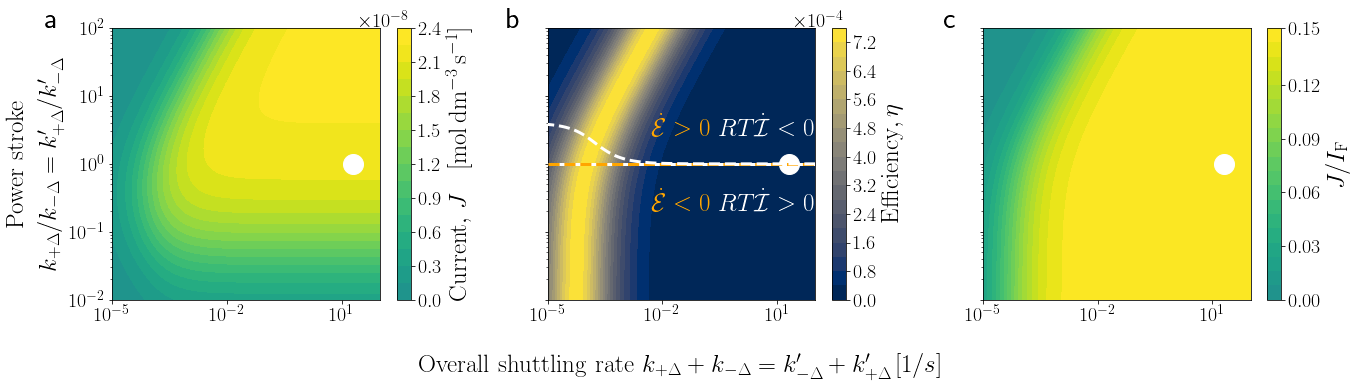

In [16]:
#energy flow at constant Kr

FigureS3, s3 = plt.subplots(1,3, figsize=(21.6,5), sharex=True, sharey=True)

xck=np.unique(np.geomspace(spA_min,spA_max,num1ck))
yck=np.unique(np.geomspace(rtA_min,rtA_max,num2ck))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

mar = 20 #markersize
labs = 25 #labelsize

im0 = s3[0].contourf(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),20,clim=( min(CKrJ[0]), max(CKrJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(CKrJ[0]), vmax=max(CKrJ[0])))
s3[0].contour(xck,yck,np.array(CKrJ).reshape(len(yck),len(xck),order='F'),[0.0],linewidths=3.0 ,colors='w')
s3[0].set_xscale('log')
s3[0].set_yscale('log')
s3[0].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar0 = FigureS3.colorbar(im0, shrink=1.0, ax=s3[0])
cbar0.set_label("$\mathrm{Current}, \, J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",size=labs)

im1 = s3[1].contourf(xck,yck,np.array(CKrEff).reshape(len(yck),len(xck),order='F'),20, cmap='cividis')
s3[1].set_xscale('log')
s3[1].set_yscale('log')
s3[1].axhline(y=1, c='w', linestyle='-',linewidth=3.0)
s3[1].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar1 = FigureS3.colorbar(im1, shrink=1.0, ax=s3[1])
cbar1.set_label("$\mathrm{Efficiency}, \eta$",size=labs)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()
s3[1].axhline(y=1, c='orange', linestyle='--',linewidth=3.0, zorder=5) 
s3[1].contour(xck,yck,np.array(CKrI).reshape(len(yck),len(xck),order='F'),[0.0],linewidths=3.0,linestyles='--' ,colors='w',zorder=10)
s3[1].text(0.3, 2.5, '$RT\dot{\mathcal{I}}<0$',size=labs, color='w')
s3[1].text(0.3, 0.2, '$RT\dot{\mathcal{I}}>0$',size=labs, color='w')
s3[1].text(0.005, 2.5, '$\dot{\mathcal{E}}>0$',size=labs, color='orange')
s3[1].text(0.005, 0.2, '$\dot{\mathcal{E}}<0$',size=labs, color='orange')


im2 = s3[2].contourf(xck,yck,np.array(CKrIFJ).reshape(len(yck),len(xck),order='F'),20,clim=( min(CKrIFJ[0]), max(CKrIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(CKrIFJ[0]), vmax=max(CKrIFJ[0])))
s3[2].contour(xck,yck,np.array(CKrIFJ).reshape(len(yck),len(xck),order='F'),[0.0],linewidths=3.0 ,colors='w')
s3[2].set_xscale('log')
s3[2].set_yscale('log')
s3[2].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar2 = FigureS3.colorbar(im2, shrink=1.0, ax=s3[2],ticks=[0.,0.03,0.06,0.09,0.12,0.15])
cbar2.set_label("$J/I_\mathrm{F}$",size=labs)


#settings
FigureS3.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3)


s3[0].set_ylabel("$\mathrm{Power \, \, stroke}$ \n $k_{+\Delta}/k_{-\Delta} = k'_{+\Delta}/k'_{-\Delta}$",linespacing=1.5,size=labs,)
s3[1].set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate} \, \, k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \, [1/s]$",size=labs)
s3[1].xaxis.set_label_coords(0.5,-0.2)

s3[0].text(-0.25, 1.0, 'a', fontproperties=arialbold ,transform=s3[0].transAxes,  fontsize=30,  fontweight='bold')
s3[1].text(-0.15, 1.0, 'b', fontproperties=arialbold ,transform=s3[1].transAxes,  fontsize=30,  fontweight='bold')
s3[2].text(-0.15, 1.0, 'c', fontproperties=arialbold ,transform=s3[2].transAxes,  fontsize=30,  fontweight='bold')


Supplementary Figure 5:

/tmp/ipykernel_4540/1495647573.py:14: UserWarning: The following kwargs were not used by contour: 'clim'
  im0 = s4[0].contourf(xvk,yvk,np.array(VKrJ).reshape(len(yvk),len(xvk),order='F'),20,clim=( min(VKrJ[0]), max(VKrJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(VKrJ[0]), vmax=max(VKrJ[0])))
/tmp/ipykernel_4540/1495647573.py:39: UserWarning: The following kwargs were not used by contour: 'clim'
  im2 = s4[2].contourf(xvk,yvk,np.array(VKrIFJ).reshape(len(yvk),len(xvk),order='F'),20,clim=( min(VKrIFJ[0]), max(VKrIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(VKrIFJ[0]), vmax=max(VKrIFJ[0])))


Text(-0.15, 1.0, 'c')

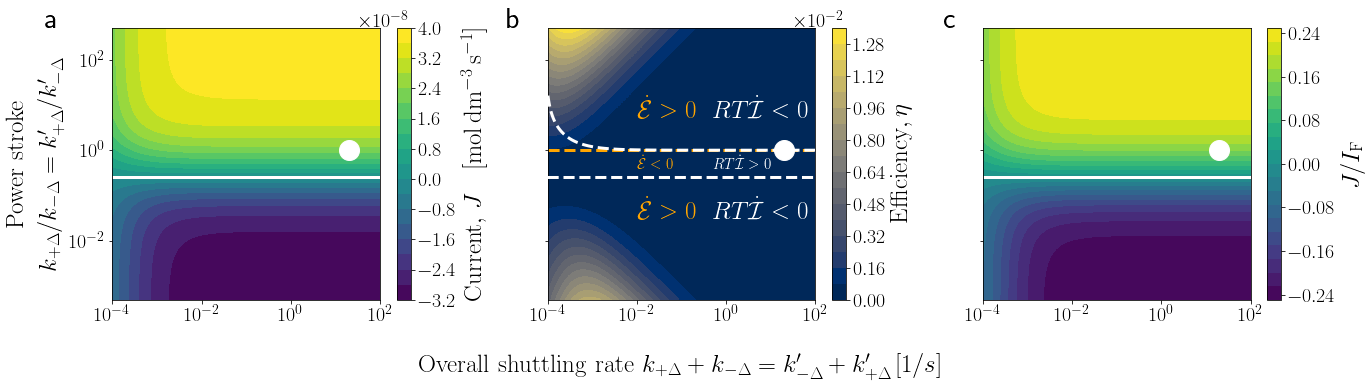

In [17]:
#energy flow with varying Kr

FigureS4, s4 = plt.subplots(1,3, figsize=(21.6,5), sharex=True, sharey=True)

xvk=np.unique(np.geomspace(spB_min,spB_max,num1ck))
yvk=np.unique(np.geomspace(rtB_min,rtB_max,num2ck))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

mar = 20 #markersize
labs = 25 #labelsize

im0 = s4[0].contourf(xvk,yvk,np.array(VKrJ).reshape(len(yvk),len(xvk),order='F'),20,clim=( min(VKrJ[0]), max(VKrJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(VKrJ[0]), vmax=max(VKrJ[0])))
s4[0].contour(xvk,yvk,np.array(VKrJ).reshape(len(yvk),len(xvk),order='F'),[0.0],linewidths=3.0 ,colors='w')
s4[0].set_xscale('log')
s4[0].set_yscale('log')
s4[0].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar0 = FigureS4.colorbar(im0, shrink=1.0, ax=s4[0])
cbar0.set_label("$\mathrm{Current}, \, J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",size=labs)

im1 = s4[1].contourf(xvk,yvk,np.array(VKrEff).reshape(len(yvk),len(xvk),order='F'),20, cmap='cividis')
s4[1].set_xscale('log')
s4[1].set_yscale('log')
s4[1].axhline(y=1, c='orange', linestyle='--',linewidth=3.0)
s4[1].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar1 = FigureS4.colorbar(im1, shrink=1.0, ax=s4[1])
cbar1.set_label("$\mathrm{Efficiency}, \eta$",size=labs)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()
s4[1].contour(xvk,yvk,np.array(VKrI).reshape(len(yvk),len(xvk),order='F'),[0.0],linewidths=3.0,linestyles='--' ,colors='w',zorder=10)
s4[1].text(0.5, 5., '$RT\dot{\mathcal{I}}<0$', size=labs, color='w')
s4[1].text(0.5, 0.4, '$RT\dot{\mathcal{I}}>0$', size=15, color='w')
s4[1].text(0.5, 0.03, '$RT\dot{\mathcal{I}}<0$',size=labs, color='w')
s4[1].text(0.01, 5., '$\dot{\mathcal{E}}>0$', size=labs, color='orange')
s4[1].text(0.01, 0.4, '$\dot{\mathcal{E}}<0$', size=15, color='orange')
s4[1].text(0.01, 0.03,'$\dot{\mathcal{E}}>0$', size=labs, color='orange')

im2 = s4[2].contourf(xvk,yvk,np.array(VKrIFJ).reshape(len(yvk),len(xvk),order='F'),20,clim=( min(VKrIFJ[0]), max(VKrIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(VKrIFJ[0]), vmax=max(VKrIFJ[0])))
s4[2].contour(xvk,yvk,np.array(VKrIFJ).reshape(len(yvk),len(xvk),order='F'),[0.0],linewidths=3.0 ,colors='w')
s4[2].set_xscale('log')
s4[2].set_yscale('log')
s4[2].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
cbar2 = FigureS4.colorbar(im2, shrink=1.0, ax=s4[2],ticks=[-0.24,-0.16,-0.08,0.0,0.08,0.16,0.24])
cbar2.set_label("$J/I_\mathrm{F}$",size=labs)

#settings
FigureS4.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3)

s4[0].set_ylabel("$\mathrm{Power \, \, stroke}$ \n $k_{+\Delta}/k_{-\Delta} = k'_{+\Delta}/k'_{-\Delta}$",linespacing=1.5,size=labs,)
s4[1].set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate} \, \, k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \, [1/s]$",size=labs)
s4[1].xaxis.set_label_coords(0.5,-0.2)

s4[0].text(-0.25, 1.0, 'a', fontproperties=arialbold ,transform=s4[0].transAxes,  fontsize=30,  fontweight='bold')
s4[1].text(-0.15, 1.0, 'b', fontproperties=arialbold ,transform=s4[1].transAxes,  fontsize=30,  fontweight='bold')
s4[2].text(-0.15, 1.0, 'c', fontproperties=arialbold ,transform=s4[2].transAxes,  fontsize=30,  fontweight='bold')


Supplementary Figure 6:

/tmp/ipykernel_4540/3369123479.py:14: UserWarning: The following kwargs were not used by contour: 'clim'
  im0 = s2[0].contourf(xps,yps,np.array(PSJ).reshape(len(yps),len(xps),order='F'),20,clim=( min(PSJ[0]), max(PSJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(PSJ[0]), vmax=max(PSJ[0])))
/tmp/ipykernel_4540/3369123479.py:15: UserWarning: No contour levels were found within the data range.
  s2[0].contour(xps,yps,np.array(PSJ).reshape(len(yps),len(xps),order='F'),[0.0],linewidths=3.0 ,colors='w')
/tmp/ipykernel_4540/3369123479.py:37: UserWarning: The following kwargs were not used by contour: 'clim'
  im2 = s2[2].contourf(xps,yps,np.array(PSIFJ).reshape(len(yps),len(xps),order='F'),20,clim=( min(PSIFJ[0]), max(PSIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(PSIFJ[0]), vmax=max(PSIFJ[0])))
/tmp/ipykernel_4540/3369123479.py:38: UserWarning: No contour levels were found within the data range.
  s2[2].contour(xps,yps,np.array(PSIFJ).reshape(len(yps),len(xps),order='F'),[0.0

Text(-0.15, 1.0, 'c')

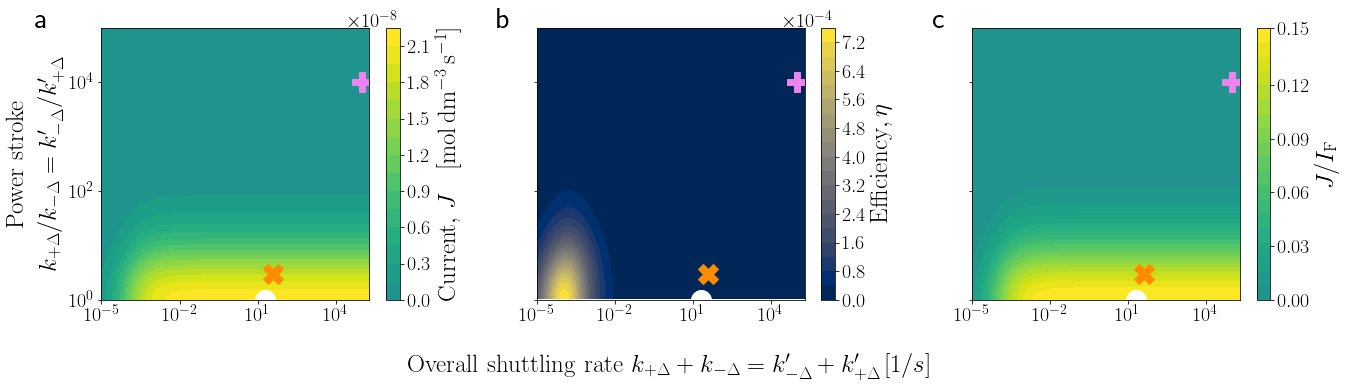

In [18]:
#binding affinities

FigureS2, s2 = plt.subplots(1,3, figsize=(21.6,5), sharex=True, sharey=True)

xps=np.unique(np.geomspace(sp_min,sp_max,numps))
yps=np.unique(np.geomspace(rt_min,rt_max,numps))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

mar = 20 #markersize
labs = 25 #labelsize

im0 = s2[0].contourf(xps,yps,np.array(PSJ).reshape(len(yps),len(xps),order='F'),20,clim=( min(PSJ[0]), max(PSJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(PSJ[0]), vmax=max(PSJ[0])))
s2[0].contour(xps,yps,np.array(PSJ).reshape(len(yps),len(xps),order='F'),[0.0],linewidths=3.0 ,colors='w')
s2[0].set_xscale('log')
s2[0].set_yscale('log')
s2[0].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
s2[0].plot(1e4*gf,1e4, marker='P',markersize=mar,c='violet')
s2[0].plot(4*gf,3, marker='X',markersize=mar,c='darkorange')
cbar0 = FigureS2.colorbar(im0, shrink=1.0, ax=s2[0])
cbar0.set_label("$\mathrm{Current}, \, J \quad [\mathrm{mol \, dm^{-3} \, s^{-1}}]$",size=labs)

im1 = s2[1].contourf(xps,yps,np.array(PSEff).reshape(len(yps),len(xps),order='F'),20, cmap='cividis')
s2[1].set_xscale('log')
s2[1].set_yscale('log')
s2[1].axhline(y=1, c='w', linestyle='-',linewidth=3.0)
s2[1].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
s2[1].plot(1e4*gf,1e4, marker='P',markersize=mar,c='violet')
s2[1].plot(4*gf,3, marker='X',markersize=mar,c='darkorange')
cbar1 = FigureS2.colorbar(im1, shrink=1.0, ax=s2[1])
cbar1.set_label("$\mathrm{Efficiency}, \eta$",size=labs)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()


im2 = s2[2].contourf(xps,yps,np.array(PSIFJ).reshape(len(yps),len(xps),order='F'),20,clim=( min(PSIFJ[0]), max(PSIFJ[0])), norm=MidpointNormalize(midpoint=0.0,vmin=min(PSIFJ[0]), vmax=max(PSIFJ[0])))
s2[2].contour(xps,yps,np.array(PSIFJ).reshape(len(yps),len(xps),order='F'),[0.0],linewidths=3.0 ,colors='w')
s2[2].set_xscale('log')
s2[2].set_yscale('log')
s2[2].plot(yc+gf,yc/gf, marker='o',markersize=mar,c='w')
s2[2].plot(1e4*gf,1e4, marker='P',markersize=mar,c='violet')
s2[2].plot(4*gf,3, marker='X',markersize=mar,c='darkorange')
cbar2 = FigureS2.colorbar(im2, shrink=1.0, ax=s2[2],ticks=[0.,0.03,0.06,0.09,0.12,0.15])
cbar2.set_label("$J/I_\mathrm{F}$",size=labs)


#settings
FigureS2.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3)

s2[0].set_ylabel("$\mathrm{Power \, \, stroke}$ \n $k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$",linespacing=1.5,size=labs,)
s2[1].set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate} \, \, k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \, [1/s]$",size=labs)
s2[1].xaxis.set_label_coords(0.5,-0.2)

s2[0].text(-0.25, 1.0, 'a', fontproperties=arialbold ,transform=s2[0].transAxes,  fontsize=30,  fontweight='bold')
s2[1].text(-0.15, 1.0, 'b', fontproperties=arialbold ,transform=s2[1].transAxes,  fontsize=30,  fontweight='bold')
s2[2].text(-0.15, 1.0, 'c', fontproperties=arialbold ,transform=s2[2].transAxes,  fontsize=30,  fontweight='bold')
